# Testing a Hypothesis and Writing a Research Note

Hypothesis: Users from Saint Petersburg spend on average more time reading and listening to books in the app than users from Moscow. Try to prove this statistically using a one-sided hypothesis test with two samples:

Null hypothesis $H_0: \mu_{\text{SPb}} \leq \mu_{\text{Moscow}}$ <br> The average time of user activity in Saint Petersburg is not more than in Moscow.

Alternative hypothesis $H_1: \mu_{\text{SPb}} > \mu_{\text{Moscow}}$ <br> The average time of user activity in Saint Petersburg is more, and this difference is statistically significant.

- Author: Maria Gryaznova
- Date: 04/24/2025

## Project goals and objectives

**Project objective** is to check whether users from St. Petersburg spend on average more time reading and listening to books in the Yandex Books app than users from Moscow. This will help to better understand user behavior in different regions and influence regional marketing strategies.

**Tasks:**
- Check the correctness of the data for analysis;
- Compare two groups;
- Test the statistical hypothesis;
- Interpret the results.

## Data description

The `yandex_knigi_data.csv` table is located in the folder https://code.s3.yandex.net/datasets/ and contains the following fields:
- `city` - the city `Moscow` or `Saint Petersburg`
- `puid` - unique user ID
- `hours` - the total number of hours the user spent reading or listening to books in the application.

## Project Contents

1. Loading and Getting to Know the Data
- Importing Libraries
- Loading and Preliminary Data Analysis
- Checking for Duplicates
- Cleaning Data (Removing Extra Columns)

2. Preparing to Run an A/B Test
- Counting Unique Users by City
- Comparing Group Sizes
- Plotting a Group Comparison Graph
- Describing Statistical Characteristics for Each Group
- Studying Data Distribution (Histogram)

3. Checking Normality of Distributions
- Plotting Histograms with KDE
- Analyzing User Activity Distribution
- Applying Levene's Test to Check for Equal Variances

4. Testing a Hypothesis Using a T-Test
- Formulating a Hypothesis
- Applying a T-Test with Equal Variances
- Applying the Mann–Whitney Test
- Interpreting the P-Value Results for Both Tests

5. Analytical Note
- Description of the Selected Test Type and Significance Level
- Interpreting the Test Results
- Conclusions Based on the P-Value Results
- Potential reasons for the obtained results
- Recommendations for further research

---

## 1. Loading data

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from scipy import stats
from scipy.stats import levene

!pip install matplotlib-venn -q
from matplotlib_venn import venn2

from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Unloading data
yandex_knigi_df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

display(yandex_knigi_df.head(5))
display(yandex_knigi_df.info())

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


None

In [3]:
# Removing extra index
yandex_knigi_df = yandex_knigi_df.drop(columns=['Unnamed: 0'])

display(yandex_knigi_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.0+ KB


None

The table consists of three fields, with correct data types and no gaps.

In [4]:
# Check for duplicate users
duplicates_id = yandex_knigi_df.duplicated(subset='puid').sum()

display(f"Number of duplicates by puid: {duplicates_id}")

'Number of duplicates by puid: 244'

In [5]:
# Check for duplicates by puid and city
duplicates = yandex_knigi_df.duplicated(subset=['puid', 'city']).sum()
print(f"Number of duplicates by puid and city: {duplicates}")

Number of duplicates by puid and city: 0


We see that there are no users with the same puid in one city in the data. That is, for each user and city, their identifier is unique, and there are no repetitions in these two columns. In theory, the same user can live in 2 cities or travel. In principle, the number of such users from the total data volume is not significant (~2.78%) and does not greatly affect the results of the analysis, but for conducting an A/B test, it is better to remove them so that a situation does not arise where the same user ends up in both study groups (the principle of group independence).

In [6]:
# Removing duplicates
yandex_knigi_df = yandex_knigi_df.drop_duplicates(subset='puid')

# Check after deletion
display(f"Final number of rows in the dataframe: {len(yandex_knigi_df)}")

'Final number of rows in the dataframe: 8540'

## Preparing for an A/B test

In [8]:
# Calculate the number of unique users by city
group_sizes = yandex_knigi_df.groupby('city')['puid'].nunique()
moscow = group_sizes['Москва']
spb = group_sizes['Санкт-Петербург']

Moscow: 6234 users
Spb: 2306 users
Percentage difference:: 63.01%


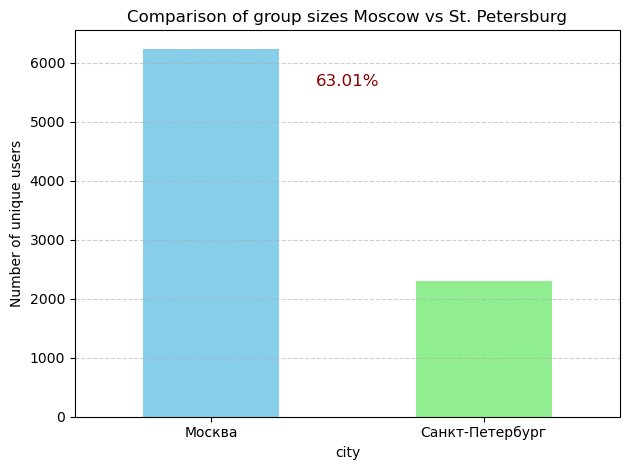

In [10]:
# Calculate the percentage difference
percent_diff = 100* abs(moscow-spb) / moscow

# Display group sizes and percentage differences
print(f"Moscow: {moscow} users")
print(f"Spb: {spb} users")
print(f"Percentage difference:: {percent_diff:.2f}%")

# Create a graph
colors = ['skyblue', 'lightgreen']
group_sizes.plot(kind='bar', color=colors)
plt.title('Comparison of group sizes Moscow vs St. Petersburg')
plt.ylabel('Number of unique users')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.text(0.5, max(group_sizes)*0.9, f"{percent_diff:.2f}%", 
         ha='center', fontsize=12, color='darkred')
plt.tight_layout()
plt.show()

We see that there are almost 3 times more users in Moscow than in St. Petersburg. This indicates unevenness in the size of the groups.

In [11]:
# Let's split the data by cities
moscow = yandex_knigi_df[yandex_knigi_df['city'] == 'Москва']
spb = yandex_knigi_df[yandex_knigi_df['city'] == 'Санкт-Петербург']

# Descriptive statistics
desc_stats = pd.DataFrame({
    'City': ['Moscow', 'Saint Petersburg'],
    'Users': [len(moscow), len(spb)],
    'Average': [moscow['hours'].mean(), spb['hours'].mean()],
    'Median': [moscow['hours'].median(), spb['hours'].median()],
    'SD': [moscow['hours'].std(), spb['hours'].std()],
    'Min': [moscow['hours'].min(), spb['hours'].min()],
    'Max': [moscow['hours'].max(), spb['hours'].max()]
})

display(desc_stats)

,City,Users,Average,Median,SD,Min,Max
0,Moscow,6234,10.881092,0.924498,36.851683,0.000018,857.209373
1,Saint Petersburg,2306,11.264433,0.875355,39.831755,0.000025,978.764775


- As mentioned above, the group sizes vary significantly: Moscow has almost 3 times more users than St. Petersburg.
- The average user activity is slightly higher in St. Petersburg — 11.26 vs. 10.88 hours. The difference is small, but potentially significant.
- The median values ​​are higher in Moscow — 0.92 vs. 0.87.
- The high standard deviation values ​​in both groups indicate a large diversity in user behavior.
- The maximum values ​​are also very high, especially in St. Petersburg (978.76).

Judging by the statistics, the distributions of user activity in Moscow and St. Petersburg are very similar in nature, but are probably not normal. Let's check this.

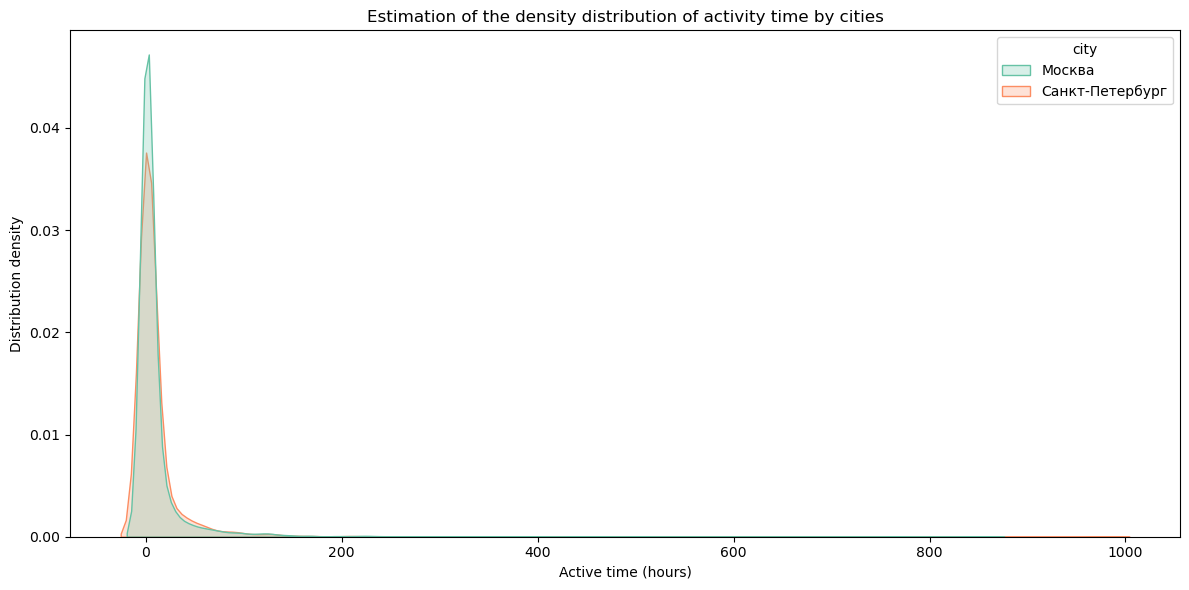

In [12]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=yandex_knigi_df, x='hours', hue='city', fill=True, common_norm=False, palette=["#66c2a5", "#fc8d62"])
plt.title('Estimation of the density distribution of activity time by cities')
plt.xlabel('Active time (hours)')
plt.ylabel('Distribution density')
plt.tight_layout()
plt.show()

The histogram shows a "peak" near 0 and a long tail to the right, confirming that the data distribution is not Gaussian.

Since we are comparing two independent samples, and the sizes of these samples are quite large (~6000 and ~2300), we could apply Welch's t-test, based on the Central Limit Theorem.

However, when analyzing the distributions, we noticed the presence of outliers that can significantly affect the result of the t-test.

Since the t-test is sensitive to outliers and requires the normality of the metric distribution, we decided to use the nonparametric Mann–Whitney U-test, which does not require normality and is more robust to outliers.

## Testing a Hypothesis

The hypothesis is as follows: users from St. Petersburg spend on average more time reading and listening to books in the app than users from Moscow. Try to prove this statistically using a one-sided hypothesis test with two samples:

- Null hypothesis H₀: The average user activity in hours in St. Petersburg is not greater than in Moscow.

- Alternative hypothesis H₁: The average user activity in St. Petersburg is greater, and this difference is statistically significant.

In [14]:
# Let's split the data by cities
spb_hours = yandex_knigi_df[yandex_knigi_df['city'] == 'Санкт-Петербург']['hours'].reset_index(drop=True)
moscow_hours = yandex_knigi_df[yandex_knigi_df['city'] == 'Москва']['hours'].reset_index(drop=True)

# Mann-Whitney test
mannwhitney_result = stats.mannwhitneyu(spb_hours, moscow_hours, alternative='greater')

# p-value derivation and interpretation for Mann-Whitney
print("Mann-Whitney test result:")
print(f"p-value: {mannwhitney_result.pvalue:.5f}")
if mannwhitney_result.pvalue < 0.05:
    print("The difference is statistically significant. The average activity of users from St. Petersburg is higher than that of users from Moscow.")
else:
    print("The difference is not statistically significant. The average activity of users from St. Petersburg is not greater than that of users from Moscow.")


Mann-Whitney test result:
p-value: 0.61896
The difference is not statistically significant. The average activity of users from St. Petersburg is not greater than that of users from Moscow.


## Analytical note

**Analysis objective:** Comparison of average user activity in hours in two cities: Moscow and St. Petersburg.

**Selected test type:** We used the non-parametric Mann–Whitney test, which does not require normal distribution and is less sensitive to extreme values. The significance level was set at `a = 0.05`.

**Test results:**

`p-value: 0.62`

**Conclusion:** The difference between average user activity in St. Petersburg and Moscow is <u>not statistically significant</u> at a significance level of 0.05.

**Interpretation of results:**

We do not reject the null hypothesis based on the test conducted, which suggests that <u>there is no statistically significant difference</u> in the average user activity between the two cities. This may be due to similar user habits in both cities, or other factors such as similar socioeconomic conditions or demographic characteristics.

**Recommendations:**

For a more accurate analysis, additional data (e.g. age, professions, preferences) can be used or the data collection methodology can be changed to reveal more pronounced differences. It is also worth considering that the sample for St. Petersburg is significantly smaller than for Moscow, which may affect the sensitivity of the test.